Load Dataset 

In [1]:
import json
import pandas as pd

# load data from the JSON file
with open("fuel_prices_raw.json", "r", encoding="utf-8") as f:
    raw = json.load(f)

df = pd.DataFrame(raw)

df


,date,ron95,ron97,diesel,series_type,diesel_eastmsia
0,2025-06-12,2.05,3.07,2.74,level,2.15
1,2025-06-05,2.05,3.07,2.74,level,2.15
2,2025-05-29,2.05,3.10,2.77,level,2.15
3,2025-05-22,2.05,3.10,2.80,level,2.15
4,2025-05-15,2.05,3.07,2.77,level,2.15
...,...,...,...,...,...,...
820,2017-05-04,-0.10,-0.10,-0.06,change_weekly,-0.06
821,2017-04-27,-0.06,-0.05,-0.07,change_weekly,-0.07
822,2017-04-20,0.03,0.02,0.05,change_weekly,0.05
823,2017-04-13,0.08,0.09,0.08,change_weekly,0.08


Data Transformation 

In [2]:
#rename columns for clarity
df = df.rename(columns={
    'date': 'Date',
    'ron95': 'RON95_price',
    'ron97': 'RON97_price',
    'diesel': 'Diesel_price',
    'diesel_eastmsia': 'Diesel_EastMY'
})

# convert date column to datetime format and sort by date
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.sort_values('Date').reset_index(drop=True)

df.head()


,Date,RON95_price,RON97_price,Diesel_price,series_type,Diesel_EastMY
0,2017-03-30,2.13,2.41,2.11,level,2.11
1,2017-04-06,2.16,2.43,2.08,level,2.08
2,2017-04-06,0.03,0.02,-0.03,change_weekly,-0.03
3,2017-04-13,0.08,0.09,0.08,change_weekly,0.08
4,2017-04-13,2.24,2.52,2.16,level,2.16


We will just choose with the level series as it provides actual weekly prices and its suitable for policy impact analysis

In [3]:
# filter the DataFrame to include only 'level' series_type
df_level = df.loc[df['series_type'] == 'level', ['Date','RON95_price','RON97_price','Diesel_price','Diesel_EastMY']]
df_level.shape, df_level.head()


((413, 5),
         Date  RON95_price  RON97_price  Diesel_price  Diesel_EastMY
 0 2017-03-30         2.13         2.41          2.11           2.11
 1 2017-04-06         2.16         2.43          2.08           2.08
 4 2017-04-13         2.24         2.52          2.16           2.16
 5 2017-04-20         2.27         2.54          2.21           2.21
 8 2017-04-27         2.21         2.49          2.14           2.14)

We observed that the data comes with weekly basis, let's calculate the difference for each week on each fuel type. 

In [4]:
# calculate the difference in prices for each fuel type
df_level['RON95_diff']   = df_level['RON95_price'].diff()
df_level['RON97_diff']   = df_level['RON97_price'].diff()
df_level['Diesel_diff']  = df_level['Diesel_price'].diff()
df_level['DieselEast_diff'] = df_level['Diesel_EastMY'].diff()

df_level.head()


,Date,RON95_price,RON97_price,Diesel_price,Diesel_EastMY,RON95_diff,RON97_diff,Diesel_diff,DieselEast_diff
0,2017-03-30,2.13,2.41,2.11,2.11,NaN,NaN,NaN,NaN
1,2017-04-06,2.16,2.43,2.08,2.08,0.03,0.02,-0.03,-0.03
4,2017-04-13,2.24,2.52,2.16,2.16,0.08,0.09,0.08,0.08
5,2017-04-20,2.27,2.54,2.21,2.21,0.03,0.02,0.05,0.05
8,2017-04-27,2.21,2.49,2.14,2.14,-0.06,-0.05,-0.07,-0.07


Replace the NAN Values to 0 for the difference

In [5]:
# Replace NaN values with 0
df_level['RON95_diff'] = df_level['RON95_diff'].fillna(0)
df_level['RON97_diff'] = df_level['RON97_diff'].fillna(0)
df_level['Diesel_diff'] = df_level['Diesel_diff'].fillna(0)
df_level['DieselEast_diff'] = df_level['DieselEast_diff'].fillna(0)

df_level.head()

,Date,RON95_price,RON97_price,Diesel_price,Diesel_EastMY,RON95_diff,RON97_diff,Diesel_diff,DieselEast_diff
0,2017-03-30,2.13,2.41,2.11,2.11,0.00,0.00,0.00,0.00
1,2017-04-06,2.16,2.43,2.08,2.08,0.03,0.02,-0.03,-0.03
4,2017-04-13,2.24,2.52,2.16,2.16,0.08,0.09,0.08,0.08
5,2017-04-20,2.27,2.54,2.21,2.21,0.03,0.02,0.05,0.05
8,2017-04-27,2.21,2.49,2.14,2.14,-0.06,-0.05,-0.07,-0.07


In [6]:
# calculate the 4-week rolling average for each fuel type
window = 4
df_level['RON95_4wk_avg']      = df_level['RON95_price'].rolling(window).mean()
df_level['RON97_4wk_avg']      = df_level['RON97_price'].rolling(window).mean()
df_level['Diesel_4wk_avg']     = df_level['Diesel_price'].rolling(window).mean()
df_level['DieselEast_4wk_avg'] = df_level['Diesel_EastMY'].rolling(window).mean()

df_level.tail(6)


,Date,RON95_price,RON97_price,Diesel_price,Diesel_EastMY,RON95_diff,RON97_diff,Diesel_diff,DieselEast_diff,RON95_4wk_avg,RON97_4wk_avg,Diesel_4wk_avg,DieselEast_4wk_avg
814,2025-05-08,2.05,3.10,2.80,2.15,0.0,-0.08,-0.08,0.0,2.05,3.1600,2.8600,2.15
815,2025-05-15,2.05,3.07,2.77,2.15,0.0,-0.03,-0.03,0.0,2.05,3.1325,2.8325,2.15
817,2025-05-22,2.05,3.10,2.80,2.15,0.0,0.03,0.03,0.0,2.05,3.1125,2.8125,2.15
820,2025-05-29,2.05,3.10,2.77,2.15,0.0,0.00,-0.03,0.0,2.05,3.0925,2.7850,2.15
821,2025-06-05,2.05,3.07,2.74,2.15,0.0,-0.03,-0.03,0.0,2.05,3.0850,2.7700,2.15
824,2025-06-12,2.05,3.07,2.74,2.15,0.0,0.00,0.00,0.0,2.05,3.0850,2.7625,2.15


Visualisation

Weekly RON95 vs RON97 Petrol Price

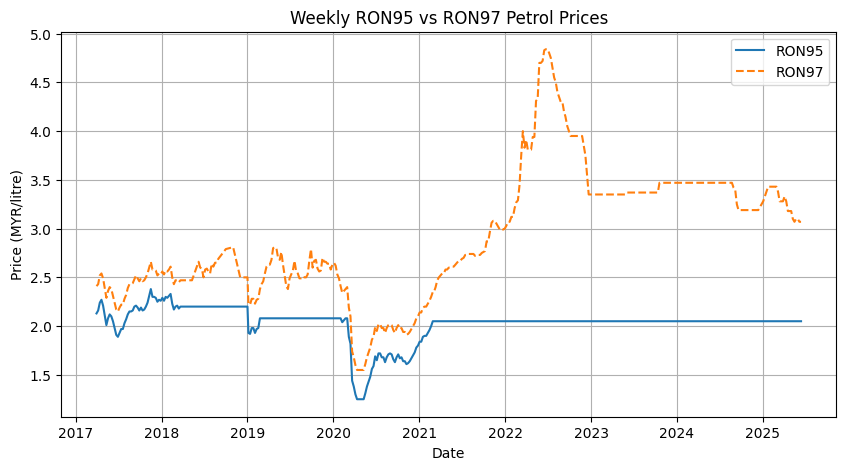

In [7]:
import matplotlib.pyplot as plt

# plot the RON95 and RON97 prices over time
plt.figure(figsize=(10,5))
plt.plot(df_level['Date'], df_level['RON95_price'], label='RON95')
plt.plot(df_level['Date'], df_level['RON97_price'], label='RON97', linestyle='--')
plt.title("Weekly RON95 vs RON97 Petrol Prices")
plt.xlabel("Date")
plt.ylabel("Price (MYR/litre)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Reset index so we can use integer-based indexing
df_temp = df_level.reset_index()

# Find the index of the max weekly jump
idx = df_temp['RON97_diff'].idxmax()
row = df_temp.loc[idx]

# Get previous week's price
if idx > 0:
    prev_price = df_temp.loc[idx - 1, 'RON97_price']
    percent_change = (row['RON97_diff'] / prev_price) * 100 if prev_price != 0 else 0
else:
    percent_change = 0

print(f"Largest RON97 weekly jump: +RM {row['RON97_diff']:.2f} "
      f"({percent_change:.2f}%) on week of {row['Date'].date()}")


Largest RON97 weekly jump: +RM 0.37 (8.55%) on week of 2022-05-26


In [12]:
# Monthly analysis (RON97)
df_level = df_level.reset_index().set_index('Date')
monthly = df_level['RON97_price'].resample('ME').last()
monthly_diff = monthly.diff()

# Get the index of the largest monthly increase
max_month_idx = monthly_diff.idxmax()
max_jump = monthly_diff.loc[max_month_idx]

# Get previous month's price safely using .shift
prev_price = monthly.shift(1).loc[max_month_idx]

# Calculate percentage change
percent_change = (max_jump / prev_price) * 100 if prev_price != 0 else 0

# Print the result
print(f"Largest RON97 monthly jump: +RM {max_jump:.2f} "
      f"({percent_change:.2f}%) from {max_month_idx - pd.offsets.MonthEnd(1):%B %Y} "
      f"to {max_month_idx:%B %Y}")


Largest RON97 monthly jump: +RM 0.76 (19.29%) from April 2022 to May 2022


### From the visual and calculation, it shows that 

RON95 shows long periods of flat price, particularly from 2021 onwards.
- Interpretation: RON95 is price-controlled by the government, hence it appears almost flat, especially since subsidies resumed in 2020.

RON97 shows significant ups and downs, largest weekly jump of 8.55% and monthly jump of 19.29%. 
- Interpretation: RON97 is market-floated, meaning its price adjusts weekly based on global oil prices, hence there's fluctuations.


Both RON95 and RON97 drop sharply in 2020.
- This reflects the global oil price crash during the COVID-19 pandemic (especially April 2020), when demand low.

RON97 rises rapidly from ~2021 to a peak in early 2022.
- This corresponds with post-pandemic economic rebound,Russia-Ukraine war disrupting global oil supply 





### Let's observe the comparison Diesel Price for Penisular and East Malaysia

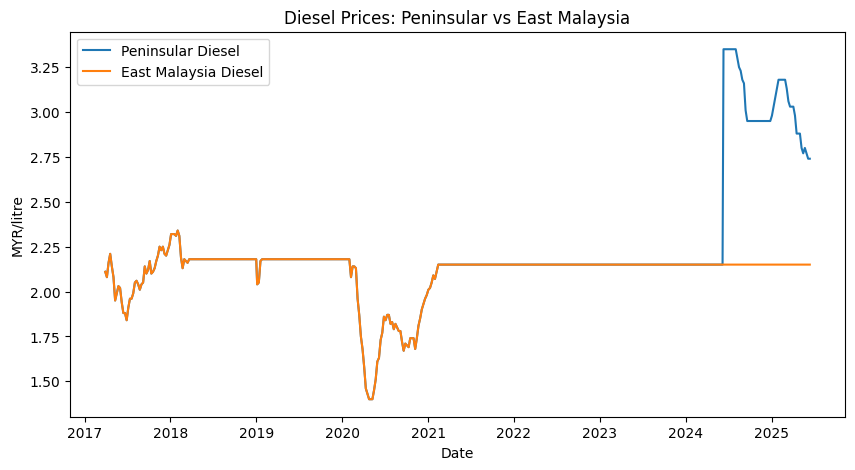

In [16]:
df_level = df_level.reset_index('Date')
# plot the diesel prices for Peninsular Malaysia and East Malaysia
plt.figure(figsize=(10,5))

plt.plot(df_level['Date'], df_level['Diesel_price'], label='Peninsular Diesel')
plt.plot(df_level['Date'], df_level['Diesel_EastMY'], label='East Malaysia Diesel')
plt.title("Diesel Prices: Peninsular vs East Malaysia")
plt.xlabel("Date")
plt.ylabel("MYR/litre")
plt.legend()
plt.show()


Before Jun 2024, it indicates that 
- Both regions had nearly identical diesel prices before June 2024.
- estimated that national diesel subsidy policy was imposed across all regions.


Let's deep dive to observe post 2024 price activity

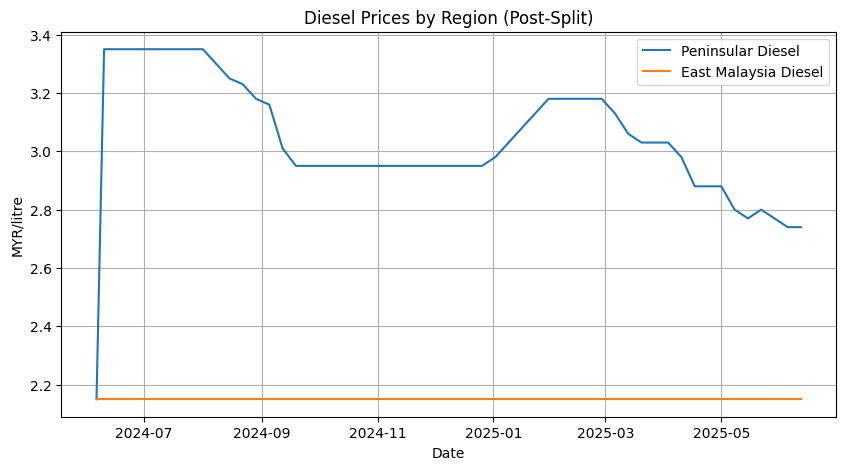

In [ ]:
# Post-split analysis for East Malaysia diesel prices

# Assuming df_level is already defined and contains the necessary data
# define the split date
split_date = pd.to_datetime("2024-06-02")

# filter to data after the split date
df_post_split = df_level[df_level["Date"] >= split_date]

# plot
plt.figure(figsize=(10,5))
plt.plot(df_post_split["Date"], df_post_split["Diesel_price"], label="Peninsular Diesel")
plt.plot(df_post_split["Date"], df_post_split["Diesel_EastMY"], label="East Malaysia Diesel")
plt.title("Diesel Prices by Region (Post-Split)")
plt.xlabel("Date")
plt.ylabel("MYR/litre")
plt.legend()
plt.grid(True)
plt.show()


After May 2024, it shows 
- Peninsular has a sharp increase in June 2024, meaning marks the end of diesel subsidies in Peninsular Malaysia.
- The graph has sharp divergence appears in 2024: Peninsular diesel price jumps above RM3.30, while East Malaysia remains flat.
- Confirms a diesel subsidy reform policy: Peninsular is floated while East Malaysia is still subsidized.



In [16]:
# Filter only post-subsidy period
post_policy = df_level[df_level['Date'] >= "2024-06-07"].copy()
post_policy['Diesel_gap'] = post_policy['Diesel_price'] - post_policy['Diesel_EastMY']

# Insight: average weekly price gap
avg_gap = post_policy['Diesel_gap'].mean()
max_gap = post_policy['Diesel_gap'].max()

print(f"Average weekly diesel price gap (Post-June 2024): RM{avg_gap:.2f}/litre")
print(f"Maximum observed gap: RM{max_gap:.2f}/litre")


Average weekly diesel price gap (Post-June 2024): RM0.91/litre
Maximum observed gap: RM1.20/litre


The average weekly diesel price gap of RM0.91/litre reflects the effective subsidy retained in East Malaysia, where diesel remains fixed at RM2.15/litre, while Peninsular prices float based on market conditions.

The maximum observed gap of RM1.20/litre highlights the financial burden shift to Peninsular consumers after subsidy removal, especially during weeks of high global oil prices.

In [17]:
pre_policy = df_level[df_level['Date'] < "2024-06-07"]
post_policy = df_level[df_level['Date'] >= "2024-06-07"]

vol_pre = pre_policy['Diesel_price'].diff().std()
vol_post = post_policy['Diesel_price'].diff().std()

print(f"Diesel Price Volatility (Std. Dev of Weekly Change)")
print(f"Before Policy: RM {vol_pre:.3f}")
print(f"After Policy:  RM {vol_post:.3f}")


Diesel Price Volatility (Std. Dev of Weekly Change)
Before Policy: RM 0.030
After Policy:  RM 0.036


Diesel price volatility increased slightly from RM0.030 to RM0.036 after the subsidy reform in June 2024, indicating greater weekly price fluctuations in Peninsular Malaysia under a market-based pricing system.

This change suggests that removal of subsidies introduced more sensitivity to global fuel price dynamics, exposing consumers to more price variability week over week.

In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calc_slope(df, col):
    df = df.copy()
    df['days'] = (df['Date'] - df['Date'].min()).dt.days
    X = df[['days']]
    y = df[col]
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

slope_pre = calc_slope(pre_policy, 'Diesel_price')
slope_post = calc_slope(post_policy, 'Diesel_price')

print(f"Weekly price trend (slope):")
print(f"Before Policy: RM {slope_pre:.4f}/day")
print(f"After Policy:  RM {slope_post:.4f}/day")


Weekly price trend (slope):
Before Policy: RM 0.0000/day
After Policy:  RM -0.0012/day


Before the policy change, the slope was RM 0.0000/day, indicating that diesel prices were essentially flat and fully controlled, with no upward or downward trend.

After the subsidy removal, the slope turned negative – RM0.0012/day, showing a gradual downward trend in diesel prices, likely reflecting market correction following an initial price spike in June 2024.

## Summary of Findings

1. Policy Impact on Diesel Prices
- After the June 2024 subsidy reform, diesel prices in Peninsular Malaysia shifted to a floating model, while East Malaysia remained subsidized at RM2.15/litre.
- This result in average weekly price gap of RM0.91/litre, max at RM1.20/litre, highlighting a clear regional price disparity.

2. Volatility and Price Movement

- Diesel price volatility increased post-policy (std dev. from RM0.030 to RM0.036/week), indicating greater price fluctuations in the deregulated Peninsular market.
- The price trend slope changed from RM0.0000/day to –RM0.0012 MYR/day, suggesting a market correction after the initial policy-driven spike.

3. RON97 Price Dynamics
- The largest weekly jump for RON97 was 8.29%. 
- The largest monthly jump occurred from May to June 2022, with a 19.29% increase, reflecting price sensitivity to external economic factors.

4. Rolling Averages and Trend Analysis
- 4-week rolling averages smooth volatility and distinguish post-policy fluctuations, especially in Peninsular diesel prices.
- East Malaysia prices remained stable, showing the effect of the continued subsidy.